In [1]:
!pip install datasets==2.19.1 nltk evaluate tqdm bert_score wandb torch transformers sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [21]:
from tqdm import tqdm
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainingArguments
import transformers
from transformers import EarlyStoppingCallback
import sys
import os
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import corpus_bleu
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("fine_tunning.ipynb"), "..")))
from datasets import load_dataset
import random
import numpy as np
import torch
from transformers import MarianMTModel, MarianTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from evaluate import load

# from transformers_models.marian.marianMT import


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
SEED_VALUE = 42


random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [ ]:
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

#GETS SYNONYM FOR A WORD

def get_synonym(word):
    synonyms = wordnet.synsets(word)
    if not synonyms:
        return None

    lemmas = synonyms[0].lemmas()
    for lemma in lemmas:
        synonym = lemma.name().replace("_", " ")
        if synonym.lower() != word.lower():
            return synonym
    return None


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
#GETS THE NEIGHBORS OF A QWERTY KEYBOARD
def build_qwerty_neighbors():
    layout = [
        "qwertyuiop",
        "asdfghjkl",
        "zxcvbnm"
    ]
    neighbors = {}

    for row in layout:
        for i, char in enumerate(row):
            neighbor_chars = []
            if i > 0:
                neighbor_chars.append(row[i - 1])
            if i < len(row) - 1:
                neighbor_chars.append(row[i + 1])
            neighbors[char] = ''.join(neighbor_chars)

    return neighbors

QWERTY_NEIGHBORS = build_qwerty_neighbors()


In [6]:
#INTRODUCE TYPOS
def typo_char(c):
    if c.lower() in QWERTY_NEIGHBORS:
        return random.choice(QWERTY_NEIGHBORS[c.lower()])
    return c

In [7]:
#CHOOSES IN 20% OF WORDS, ONE OF THE FOLLOWING NOISES
def add_noise(text, noise_prob=0.2):
    words = text.split()
    noisy_words = []

    for word in words:
        if random.random() < noise_prob:
            noise_type = random.choice(["delete_word", "duplicate_word", "shuffle", "synonym", "char_noise"])

            if noise_type == "delete_word":
                continue

            elif noise_type == "duplicate_word":
                noisy_words.extend([word, word])

            elif noise_type == "shuffle":
                if len(words) > 1:
                    idx = words.index(word)
                    if idx < len(words) - 1:
                        noisy_words.append(words[idx + 1])
                        noisy_words.append(word)
                        continue

            elif noise_type == "synonym":
                cleaned_word = word.strip('.,?!')
                synonym = get_synonym(cleaned_word.lower())
                noisy_words.append(synonym if synonym else word)

            elif noise_type == "char_noise":
                noisy_word = ""
                for char in word:
                    if random.random() < 0.2:
                        char_noise_type = random.choice(["typo", "duplicate", "delete", "replace"])
                        if char_noise_type == "typo":
                            noisy_word += typo_char(char)
                        elif char_noise_type == "duplicate":
                            noisy_word += char * 2
                        elif char_noise_type == "delete":
                            continue
                        elif char_noise_type == "replace":
                            noisy_word += random.choice("abcdefghijklmnopqrstuvwxyz")
                    else:
                        noisy_word += char
                noisy_words.append(noisy_word)
        else:
            noisy_words.append(word)

    return " ".join(noisy_words)

In [8]:
def retrieve_data(max_length=30, add_text_noise=False, noise_level=0.2, train_size=50000):
    dataset = load_dataset("wmt14", "de-en")

    raw_subset = dataset["train"].select(range(200000))

    def is_short(example):
        return len(example["translation"]["de"].split()) <= max_length and len(example["translation"]["en"].split()) <= max_length

    filtered = raw_subset.filter(is_short)

    if add_text_noise:
        def apply_noise(example):
            example["translation"]["de"] = add_noise(example["translation"]["de"], noise_level)
            example["translation"]["en"] = add_noise(example["translation"]["en"], noise_level)
            return example

        filtered = filtered.map(apply_noise)

    train_data = filtered.select(range(train_size))
    val_data = filtered.select(range(train_size, train_size+3000))
    test_data = filtered.select(range(train_size+3000, train_size+6000))

    return {
        "train": train_data,
        "validation": val_data,
        "test": test_data
    }

In [9]:
def translated(n, model):
    return model.translate_text(n)

In [10]:
data = retrieve_data()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200000 [00:00<?, ? examples/s]

In [ ]:
print(data["train"].shape)
print(data["test"].shape)
print(data["validation"].shape)

(50000, 1)
(3000, 1)
(3000, 1)


In [ ]:
data["validation"]["translation"][:10]

[{'de': 'Herr Präsident, bei dieser Richtlinie über die Etikettierung von Rindfleisch und Rindfleischerzeugnissen geht es um zwei unterschiedliche Aspekte.',
  'en': 'Mr President, this legislation on the labelling of beef has two distinct aspects.'},
 {'de': 'Erstens wird dadurch die Rückverfolgbarkeit von Rindfleischerzeugnissen sichergestellt.',
  'en': 'Firstly it ensures traceability of beef products.'},
 {'de': 'Gelegentlich treten jedoch auch in Schottland Probleme, wie zum Beispiel ein Befall mit E-Coli-Bakterien, auf.',
  'en': 'Occasionally, however, there is a problem such as the E-coli outbreak in Scotland.'},
 {'de': 'Zweitens kann durch die Etikettierung festgestellt werden, aus welchem Land oder welchen Ländern das Rindfleisch stammt.',
  'en': 'Secondly, labelling will identify the country or countries of origin of beef.'},
 {'de': 'Durch die BSE-Krise sind die möglichen Gesundheitsgefahren in den Vordergrund gerückt, die durch den Verzehr von Rindfleisch auftreten könn

In [ ]:
data["test"]["translation"][:10]

[{'de': 'Rassismus und Fremdenfeindlichkeit sind ein schwerwiegendes und ernst zu nehmendes Problem in der gesamten Union.',
  'en': 'Racism and xenophobia are a serious problem throughout the Union and one that must be taken seriously.'},
 {'de': 'Überall dort, wo es auftritt, ist es mit allen Mitteln zu bekämpfen.',
  'en': 'It must be combated by every means available wherever it arises.'},
 {'de': 'Was ich mir von der Beobachtungsstelle nicht erwarte, ist die Einmischung in tagespolitische Fragen und die Ausübung dieses Mandats mit ideologischer Brille.',
  'en': 'What I do not expect of the Monitoring Centre is interference in day-to-day political matters and to exercise its mandate with an ideological bias.'},
 {'de': 'Denn hinter dem Begriff Rassismus und Fremdenfeindlichkeit stehen Menschen und deren Schicksale, die sich nicht zum Mißbrauch für eine Politshow eignen.',
  'en': 'Because underlying the concept of racism and xenophobia there are people and their destinies, and the

In [ ]:
data["train"]["translation"][:10]

[{'de': 'Wiederaufnahme der Sitzungsperiode',
  'en': 'Resumption of the session'},
 {'de': 'Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.',
  'en': 'You have requested a debate on this subject in the course of the next few days, during this part-session.'},
 {'de': 'Ich bitte Sie, sich zu einer Schweigeminute zu erheben.',
  'en': "Please rise, then, for this minute' s silence."},
 {'de': '(Das Parlament erhebt sich zu einer Schweigeminute.)',
  'en': "(The House rose and observed a minute' s silence)"},
 {'de': 'Frau Präsidentin, zur Geschäftsordnung.',
  'en': 'Madam President, on a point of order.'},
 {'de': 'Wie Sie sicher aus der Presse und dem Fernsehen wissen, gab es in Sri Lanka mehrere Bombenexplosionen mit zahlreichen Toten.',
  'en': 'You will be aware from the press and television that there have been a number of bomb explosions and killings in Sri Lanka.'},
 {'de': 'Ja, Herr Evans, ich denke, daß eine derart

In [ ]:


model_name = "Helsinki-NLP/opus-mt-en-de"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
english = [n["en"] for n in data["train"]["translation"]]
german = [n["de"] for n in data["train"]["translation"]]

In [ ]:
data

{'train': Dataset({
     features: ['translation'],
     num_rows: 50000
 }),
 'validation': Dataset({
     features: ['translation'],
     num_rows: 3000
 }),
 'test': Dataset({
     features: ['translation'],
     num_rows: 3000
 })}

In [ ]:
def preprocess(batch):
    src_texts = [ex["en"] for ex in batch["translation"]]
    tgt_texts = [ex["de"] for ex in batch["translation"]]

    model_inputs = tokenizer(
        src_texts,
        truncation=True,
        padding="max_length",
        max_length=40
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            tgt_texts,
            truncation=True,
            padding="max_length",
            max_length=40
        )["input_ids"]

    labels = [
        [(token if token != tokenizer.pad_token_id else -100) for token in seq]
        for seq in labels
    ]

    model_inputs["labels"] = labels
    return model_inputs


In [ ]:
tokenized_data = {
    "train": data["train"].map(preprocess, batched = True),
    "validation": data["validation"].map(preprocess, batched=True)
}


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:


bleu = evaluate.load("bleu")
test_subset = data["test"].select(range(3000))

src_texts = [ex["translation"]["en"] for ex in test_subset]
references = [[ex["translation"]["de"]] for ex in test_subset]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
batch_size = 16
predictions = []

for i in tqdm(range(0, len(src_texts), batch_size), desc="Translating"):
    batch = src_texts[i:i + batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=60)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(**inputs, num_beams=4, max_length=60, early_stopping=True)
    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    predictions.extend(preds)


Translating: 100%|██████████| 188/188 [01:25<00:00,  2.21it/s]


In [ ]:
references[:10]

[['Rassismus und Fremdenfeindlichkeit sind ein schwerwiegendes und ernst zu nehmendes Problem in der gesamten Union.'],
 ['Überall dort, wo es auftritt, ist es mit allen Mitteln zu bekämpfen.'],
 ['Was ich mir von der Beobachtungsstelle nicht erwarte, ist die Einmischung in tagespolitische Fragen und die Ausübung dieses Mandats mit ideologischer Brille.'],
 ['Denn hinter dem Begriff Rassismus und Fremdenfeindlichkeit stehen Menschen und deren Schicksale, die sich nicht zum Mißbrauch für eine Politshow eignen.'],
 ['Was ich ablehne, ist die Tatsache, daß dieser undifferenzierte Entschließungsantrag auch von jenen österreichischen Abgeordneten kommt, die sich angeblich für mein Heimatland einsetzen.'],
 ['Es ist jedoch ständige Praxis der Kommission, zu Gerichtsverfahren von Einzelpersonen in den Mitgliedstaaten keine Stellungnahme abzugeben.'],
 ['Das gilt insbesondere für den vorliegenden Fall, der außerhalb des Anwendungsbereichs des EG-Rechts liegt.'],
 ['Zudem kann sich die Kommissi

In [ ]:
predictions[:10]


['Rassismus und Fremdenfeindlichkeit sind ein ernstes Problem in der gesamten Union, das ernst genommen werden muss.',
 'Sie muss überall dort bekämpft werden, wo sie sich befindet.',
 'Was ich von der Beobachtungsstelle nicht erwarte, ist die Einmischung in die alltäglichen politischen Angelegenheiten und die Ausübung ihres Mandats mit ideologischer Voreingenommenheit.',
 'Denn dem Konzept von Rassismus und Fremdenfeindlichkeit zugrunde liegen Menschen und ihre Schicksale, und sie sollten nicht dazu benutzt werden, eine Art politische Show zu veranstalten.',
 'Ich bin dagegen, dass dieser vereinfachte Entschließungsantrag auch von den österreichischen Abgeordneten eingereicht wird, die vorgeben, mein Heimatland zu unterstützen.',
 'Dennoch ist es die übliche Praxis der Kommission, keine Stellungnahme zu Gerichtsverfahren abzugeben, die Einzelpersonen in den Mitgliedstaaten betreffen.',
 'Dies gilt insbesondere für diesen Fall, der nicht in den Anwendungsbereich des EU-Rechts fällt.',


In [ ]:
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
bleu_score = bleu.compute(predictions=predictions, references=references)
meteor_score = meteor.compute(predictions=predictions, references=[r[0] for r in references])
bert_score = bertscore.compute(predictions=predictions, references=[r[0] for r in references], lang="de")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
bleu_score_BEFORE = bleu_score
meteor_score_BEFORE = meteor_score
bert_score_BEFORE = bert_score

In [ ]:


print(f"BLEU before fine-tunning score: {bleu_score['bleu']:.4f}")

print("METEOR:", meteor_score["meteor"])
print("BERTScore:")
bert_precision = sum(bert_score['precision']) / len(bert_score['precision']) # TP/(TP+FP)
bert_recall = sum(bert_score['recall']) / len(bert_score['recall']) # TP/(TP+FN)
bert_f1 = sum(bert_score['f1']) / len(bert_score['f1'])
print(f"  Precision: {bert_precision:.4f}")
print(f"  Recall:    {bert_recall:.4f}")
print(f"  F1:        {bert_f1:.4f}")


BLEU before fine-tunning score: 0.2683
METEOR: 0.5338372246803124
BERTScore:
  Precision: 0.8587
  Recall:    0.8570
  F1:        0.8576


<ipython-input-28-81d63e288475>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Metric', y='Score', data=data, palette=palette)


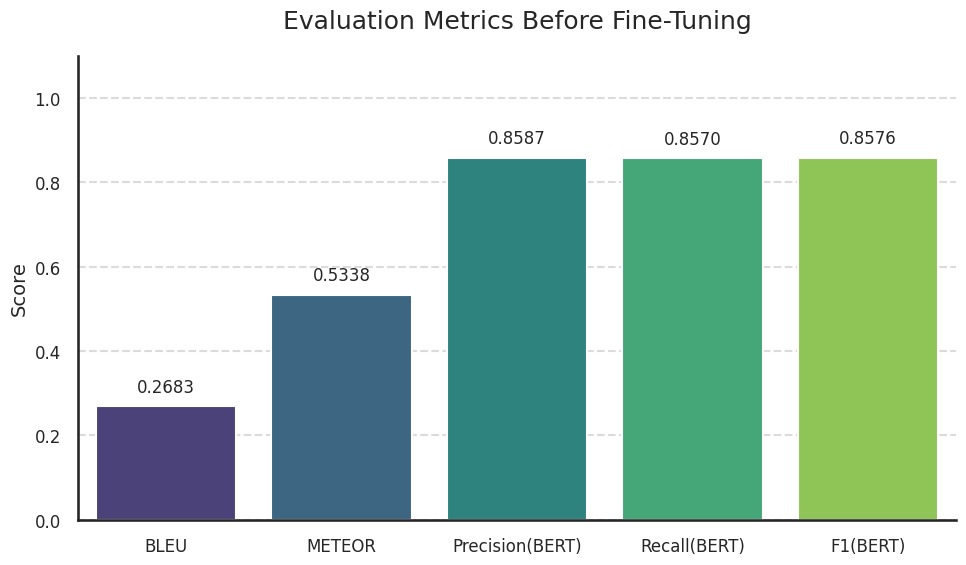

In [ ]:



data = pd.DataFrame({
    'Metric': ['BLEU', 'METEOR', 'Precision(BERT)', 'Recall(BERT)', 'F1(BERT)'],
    'Score': [bleu_score['bleu'], meteor_score["meteor"], bert_precision, bert_recall, bert_f1]
})

sns.set(style="white", context="talk")
palette = sns.color_palette("viridis", len(data))

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Score', data=data, palette=palette)

for i, row in data.iterrows():
    ax.text(i, row['Score'] + 0.025, f"{row['Score']:.4f}",
            ha='center', va='bottom',  fontsize=12)

plt.title("Evaluation Metrics Before Fine-Tuning", fontsize=18, pad=20)
plt.ylim(0, 1.1)
plt.ylabel("Score", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(58101, 512, padding_idx=58100)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(58101, 512, padding_idx=58100)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [ ]:

bleu_metric = load("bleu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    list_of_lists = [[lbl] for lbl in decoded_labels]
    flat_list= decoded_labels



    bleu = bleu_metric.compute(predictions=decoded_preds, references=list_of_lists)

    meteor_score = meteor.compute(predictions=decoded_preds, references=list_of_lists)

    bert_score = bertscore.compute(predictions=decoded_preds, references=flat_list, lang="de")
    bert_precision = sum(bert_score['precision']) / len(bert_score['precision']) # TP/(TP+FP)
    bert_recall = sum(bert_score['recall']) / len(bert_score['recall']) # TP/(TP+FN)
    bert_f1 = sum(bert_score['f1']) / len(bert_score['f1'])

    return {
        "bleu": bleu["bleu"],
        "meteor": meteor_score["meteor"],
        "bertscore_precision": bert_precision,
        "bertscore_recall": bert_recall,
        "bertscore_f1": bert_f1
    }


In [ ]:
!pip install --upgrade transformers


In [ ]:
pip install --upgrade "transformers==4.36.2"


  Using cached transformers-4.36.2-py3-none-any.whl.metadata (126 kB)
  Using cached tokenizers-0.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.36.2-py3-none-any.whl (8.2 MB)
Using cached tokenizers-0.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.3
    Uninstalling transformers-4.52.3:
      Successfully uninstalled transformers-4.52.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.2 which is incompatible.


In [12]:
import transformers
print(transformers.__version__)

4.52.2


In [13]:
print(transformers.Seq2SeqTrainingArguments.__init__.__code__.co_varnames)



('self', 'output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'eval_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'torch_empty_cache_steps', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'restore_callback_states_from_checkpoint', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'use_ipex', 'bf16', 'fp16', 'fp16_opt_level', 'half_precision_backend',

In [14]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [17]:

training_args = Seq2SeqTrainingArguments(
    output_dir="./marianmt-finetuned",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    num_train_epochs=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    predict_with_generate=True,
    logging_dir="./logs",
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    logging_steps=500,
    lr_scheduler_type="constant",
    load_best_model_at_end=True,
    #metric_for_best_model="bleu",
    #greater_is_better=True
)


NameError: name 'torch' is not defined

In [ ]:


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],

)

trainer.train()


In [ ]:

import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd

train_set_sizes = [20000, 50000, 70000, 100000]
metrics_container = {n:{} for n in train_set_sizes}


for train_set_s in train_set_sizes:
    data = retrieve_data(train_size=train_set_s)

    tokenized_data = {
        "train": data["train"].map(preprocess, batched=True),
        "validation": data["validation"].map(preprocess, batched=True)
    }

    model_name = "Helsinki-NLP/opus-mt-en-de"
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)

    training_args = Seq2SeqTrainingArguments(
    output_dir="./marianmt-finetuned",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    predict_with_generate=True,
    logging_dir="./logs",
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    logging_steps=500,
    lr_scheduler_type="constant",
    load_best_model_at_end=True,
    #metric_for_best_model="bleu",
    #greater_is_better=True
    )

    trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],

  )

    trainer.train()


    log_history   = trainer.state.log_history
    epoch_entries = [e for e in log_history if "epoch" in e]

    metrics = [
        "loss",
        "learning_rate",
        "eval_loss",
        "eval_bleu",
        "eval_meteor",
        "eval_bertscore_precision",
        "eval_bertscore_recall",
        "eval_bertscore_f1"
    ]
    names = {
        "loss": "Training Loss",
        "learning_rate": "Learning Rate",
        "eval_loss": "Validation Loss",
        "eval_bleu": "BLEU",
        "eval_meteor": "METEOR",
        "eval_bertscore_precision": "BERTScore Precision",
        "eval_bertscore_recall": "BERTScore Recall",
        "eval_bertscore_f1": "BERTScore F1"
    }

    n = len(metrics)
    cols = 4
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = axes.flatten()

    cmap = plt.get_cmap('tab10')

    for i, metric in enumerate(metrics):
        ax = axes[i]
        currdata = [(e["epoch"], e[metric]) for e in epoch_entries if metric in e]
        if not currdata:
            ax.set_visible(False)
            continue
        epochs, values = zip(*currdata)

        ax.plot(epochs, values,
                marker='o',
                linestyle='-',
                color=cmap(i % 10),
                label=names.get(metric, metric))
        ax.set_title(names.get(metric, metric), fontsize=12, fontweight='bold')
        ax.set_xlabel("Epoch")
        ax.set_ylabel(names.get(metric, metric))
        ax.grid(linestyle='--', alpha=0.5)

    for ax in axes[n:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

    data = retrieve_data()
    model = trainer.model
    tokenizer = trainer.tokenizer


    bleu = evaluate.load("bleu")
    test_subset = data["test"].select(range(3000))

    src_texts = [ex["translation"]["en"] for ex in test_subset]
    references = [[ex["translation"]["de"]] for ex in test_subset]

    batch_size = 16
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    predictions = []

    for i in tqdm(range(0, len(src_texts), batch_size), desc="Translating"):
        batch = src_texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=60)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(**inputs, max_length=60, num_beams=4, early_stopping=True)
        preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        predictions.extend(preds)


    bleu_score = bleu.compute(predictions=predictions, references=references)
    meteor_score = meteor.compute(predictions=predictions, references=[r[0] for r in references])
    bert_score = bertscore.compute(predictions=predictions, references=[r[0] for r in references], lang="de")

    bleu_score_AFTER = bleu_score
    meteor_score_AFTER = meteor_score
    bert_score_AFTER = bert_score

    bert_precision = sum(bert_score['precision']) / len(bert_score['precision']) # TP/(TP+FP)
    bert_recall = sum(bert_score['recall']) / len(bert_score['recall']) # TP/(TP+FN)
    bert_f1 = sum(bert_score['f1']) / len(bert_score['f1'])

    print(f"BLEU:   {bleu_score['bleu']:.4f}")
    print(f"METEOR: {meteor_score['meteor']:.4f}")
    print("BERTScore:")
    print(f"  Precision: {bert_precision:.4f}")
    print(f"  Recall:    {bert_recall:.4f}")
    print(f"  F1:        {bert_f1:.4f}")


    data = pd.DataFrame({
        'Metric': ['BLEU', 'METEOR', 'Precision(BERT)', 'Recall(BERT)', 'F1(BERT)'],
        'Score': [bleu_score['bleu'], meteor_score["meteor"], bert_precision, bert_recall, bert_f1]
    })

    sns.set(style="white", context="talk")
    palette = sns.color_palette("viridis", len(data))

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Metric', y='Score', data=data, palette=palette)

    for i, row in data.iterrows():
        ax.text(i, row['Score'] + 0.025, f"{row['Score']:.4f}",
                ha='center', va='bottom',  fontsize=12)

    plt.title(f"Evaluation Metrics After Fine-Tuning (3 epochs, training set size = {train_set_s})", fontsize=18, pad=20)
    plt.ylim(0, 1.1)
    plt.ylabel("Score", fontsize=14)
    plt.xlabel("")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.show()

    metrics_container[train_set_s] = {
        "BLEU":   bleu_score["bleu"],
        "METEOR": meteor_score["meteor"],
        "BERT_P": bert_precision,
        "BERT_R": bert_recall,
        "BERT_F1": bert_f1,
    }

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


NameError: name 'Seq2SeqTrainingArguments' is not defined

In [ ]:
summary_df = (
    pd.DataFrame.from_dict(metrics_container, orient="index")
      .reset_index()
      .rename(columns={"index": "Train_Size"})
      .sort_values("Train_Size")
)

print(summary_df)

plt.figure(figsize=(10,6))
for metric in ["BLEU", "METEOR", "BERT_F1"]:
    sns.lineplot(
        x="Train_Size", y=metric, data=summary_df,
        marker="o", label=metric
    )
plt.title("Metrics vs training set sizes")
plt.ylabel("Score")
plt.grid(linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import math

log_history   = trainer.state.log_history
epoch_entries = [e for e in log_history if "epoch" in e]

metrics = [
    "loss",
    "learning_rate",
    "eval_loss",
    "eval_bleu",
    "eval_meteor",
    "eval_bertscore_precision",
    "eval_bertscore_recall",
    "eval_bertscore_f1"
]
names = {
    "loss": "Training Loss",
    "learning_rate": "Learning Rate",
    "eval_loss": "Validation Loss",
    "eval_bleu": "BLEU",
    "eval_meteor": "METEOR",
    "eval_bertscore_precision": "BERTScore Precision",
    "eval_bertscore_recall": "BERTScore Recall",
    "eval_bertscore_f1": "BERTScore F1"
}

n = len(metrics)
cols = 4
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = axes.flatten()

cmap = plt.get_cmap('tab10')

for i, metric in enumerate(metrics):
    ax = axes[i]
    currdata = [(e["epoch"], e[metric]) for e in epoch_entries if metric in e]
    if not currdata:
        ax.set_visible(False)
        continue
    epochs, values = zip(*currdata)

    ax.plot(epochs, values,
            marker='o',
            linestyle='-',
            color=cmap(i % 10),
            label=names.get(metric, metric))
    ax.set_title(names.get(metric, metric), fontsize=12, fontweight='bold')
    ax.set_xlabel("Epoch")
    ax.set_ylabel(names.get(metric, metric))
    ax.grid(linestyle='--', alpha=0.5)

for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
data = retrieve_data()
model = trainer.model
tokenizer = trainer.tokenizer

In [ ]:
bleu = evaluate.load("bleu")
test_subset = data["test"].select(range(3000))

src_texts = [ex["translation"]["en"] for ex in test_subset]
references = [[ex["translation"]["de"]] for ex in test_subset]

batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
predictions = []

for i in tqdm(range(0, len(src_texts), batch_size), desc="Translating"):
    batch = src_texts[i:i + batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=60)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=60, num_beams=4, early_stopping=True)
    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    predictions.extend(preds)

In [ ]:
references[:10]

In [ ]:
predictions[:10]

In [ ]:
bleu_score = bleu.compute(predictions=predictions, references=references)
meteor_score = meteor.compute(predictions=predictions, references=[r[0] for r in references])
bert_score = bertscore.compute(predictions=predictions, references=[r[0] for r in references], lang="de")

In [ ]:
bleu_score_AFTER = bleu_score
meteor_score_AFTER = meteor_score
bert_score_AFTER = bert_score

In [ ]:
bert_precision = sum(bert_score['precision']) / len(bert_score['precision']) # TP/(TP+FP)
bert_recall = sum(bert_score['recall']) / len(bert_score['recall']) # TP/(TP+FN)
bert_f1 = sum(bert_score['f1']) / len(bert_score['f1'])

print(f"BLEU:   {bleu_score['bleu']:.4f}")
print(f"METEOR: {meteor_score['meteor']:.4f}")
print("BERTScore:")
print(f"  Precision: {bert_precision:.4f}")
print(f"  Recall:    {bert_recall:.4f}")
print(f"  F1:        {bert_f1:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



data = pd.DataFrame({
    'Metric': ['BLEU', 'METEOR', 'Precision(BERT)', 'Recall(BERT)', 'F1(BERT)'],
    'Score': [bleu_score['bleu'], meteor_score["meteor"], bert_precision, bert_recall, bert_f1]
})

sns.set(style="white", context="talk")
palette = sns.color_palette("viridis", len(data))

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Score', data=data, palette=palette)

for i, row in data.iterrows():
    ax.text(i, row['Score'] + 0.025, f"{row['Score']:.4f}",
            ha='center', va='bottom',  fontsize=12)

plt.title("Evaluation Metrics After Fine-Tuning", fontsize=18, pad=20)
plt.ylim(0, 1.1)
plt.ylabel("Score", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

bleu_before= bleu_score_BEFORE["bleu"]
meteor_before= meteor_score_BEFORE["meteor"]
prec_before= np.mean(bert_score_BEFORE["precision"])
rec_before= np.mean(bert_score_BEFORE["recall"])
f1_before= np.mean(bert_score_BEFORE["f1"])

bleu_after= bleu_score_AFTER["bleu"]
meteor_after= meteor_score_AFTER["meteor"]
prec_after= np.mean(bert_score_AFTER["precision"])
rec_after= np.mean(bert_score_AFTER["recall"])
f1_after= np.mean(bert_score_AFTER["f1"])

before = [bleu_before, meteor_before, prec_before, rec_before, f1_before]
after  = [bleu_after,  meteor_after,  prec_after,  rec_after,  f1_after]
metrics = [
    "BLEU",
    "METEOR",
    "BERTScore Precision",
    "BERTScore Recall",
    "BERTScore F1"
]

rows, cols = 2, 3
fig, axes = plt.subplots(
    rows, cols,
    figsize=(14, 8),
    constrained_layout=True
)
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < len(metrics):
        vals = [before[idx], after[idx]]
        ax.bar(
            ["Before", "After"],
            vals,
            color=["orange", "green"],
            width=0.7
        )
        ax.set_title(metrics[idx], fontsize=12, fontweight='bold')
        ax.set_ylabel("Score")
        ax.grid(axis='y', linestyle='--', alpha=0.5)

        top = max(vals) * 1.25
        ax.set_ylim(0, top)

        for i, v in enumerate(vals):
            ax.text(
                i, v + top * 0.02,
                f"{v:.3f}",
                ha='center',
                va='bottom',
                fontsize=10
            )
    else:
        ax.axis("off")



plt.show()


In [ ]:
# model.save_pretrained("marianmt-finetuned")
# tokenizer.save_pretrained("marianmt-finetuned")
